In [58]:
import numpy as np
import math
import matplotlib.pyplot as plt

from numpy import linalg

from sklearn.datasets import load_wine
from sklearn.naive_bayes import GaussianNB

samples, labels = load_wine(return_X_y=True)
labels = np.array(labels)

In [2]:
# must set one of numPC or accuracy
def pca(X, dim=None, accuracy=None):
    u, d, v = linalg.svd(X)
    if accuracy is not None:
        energy = linalg.norm(X)**2
        sumEig = 0
        for i, eigval in enumerate(list(d)):
            sumEig += eigval**2
            if sumEig / energy >= accuracy:
                dim = i + 1
                break
    return u[:, :dim]

# Standardize Data

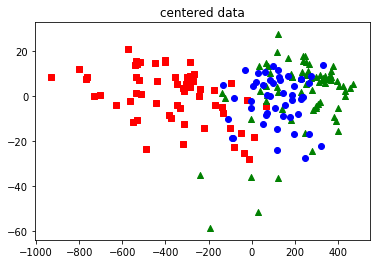

In [74]:
center_data = samples - np.mean(samples, axis=0)[np.newaxis,:]
center_comp = pca(center_data.T, dim=2)
center_feat = center_data @ center_comp

colors = ['r', 'g', 'b']
markers = ['s', '^', 'o']

for i, (c, m) in enumerate(zip(colors, markers)):
    class_samp = center_feat[np.where(labels==i)]
    plt.scatter(class_samp[:,0], class_samp[:,1], c=c,marker=m)

plt.title('centered data')
plt.show()

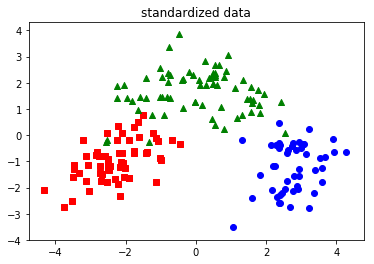

In [77]:
variances = np.var(center_data, axis=0)[np.newaxis, :]
std_data = center_data / np.sqrt(variances)
std_comp = pca(std_data.T, dim=2)
std_feat = std_data @ std_comp

for i, (c, m) in enumerate(zip(colors, markers)):
    class_samp = std_feat[np.where(labels==i)]
    plt.scatter(class_samp[:,0], class_samp[:,1], c=c,marker=m)

plt.title('standardized data')
plt.show()

The standardized data creates better PCA features. In the plot for standardized data, the classes appear to be much more separable.

# Naive Bayes Classification

In [50]:
class NaiveBayesClassifier:
    
    def __init__(self, data, labels, priors):
        self.priors = priors
        self.n_classes = len(priors)
        self.n_feat = data.shape[1]
        self.means = np.zeros((self.n_classes, self.n_feat))
        self.variances = np.zeros((self.n_classes, self.n_feat))
        for i in range(self.n_classes):
            class_data = data[np.where(labels==i)]
            self.means[i] = np.average(class_data, axis=0)
            self.variances[i] = np.var(class_data, axis=0)
    
    def classify(self, sample):
        probs = np.copy(self.priors)
        for i in range(self.n_classes):
            for s, m, v in zip(sample, self.means[i], self.variances[i]):
                prob = 1/math.sqrt(2*math.pi*v)*math.exp(-(s-m)**2/(2*v))
                probs[i] *= prob
        return np.argmax(probs)

In [81]:
priors = np.array([1/3 for i in range(3)])[:, np.newaxis]

indices = np.arange(len(labels))
np.random.shuffle(indices)
splits = np.array_split(indices, 5)

accuracies = np.zeros((3, 5))

for data_index, data in enumerate([center_feat, std_feat]):
    for i in range(5):
        test_data = data[splits[i],:]
        train_data = np.delete(data, splits[i], axis=0)
        train_labels = np.delete(labels, splits[i])
        classifier = NaiveBayesClassifier(train_data, train_labels, priors)
        err = 0
        for f, l in zip(test_data, labels[splits[i]]):
            res = classifier.classify(f)
            if res != l:
                err += 1
        accuracies[data_index, i] = (len(splits[i]) - err) / len(splits[i])

for i in range(5):
    test_data = std_feat[splits[i],:]
    train_data = np.delete(std_feat, splits[i], axis=0)
    train_labels = np.delete(labels, splits[i])  
    classifier = GaussianNB(priors=priors)
    classifier.fit(train_data, train_labels)
    err = 0
    res = classifier.predict(test_data)
    for r, l in zip(res, labels[splits[i]]):
        if r != l:
            err += 1
    accuracies[2, i] = (len(splits[i]) - err) / len(splits[i])
  
print('ACCURACIES:')
print(accuracies)
print('MEANS')
print(np.mean(accuracies, axis=1))
print('VARIANCES')
print(np.var(accuracies, axis=1))

ACCURACIES:
[[0.86111111 0.66666667 0.80555556 0.74285714 0.74285714]
 [0.94444444 1.         0.94444444 0.94285714 1.        ]
 [0.94444444 1.         0.94444444 0.94285714 1.        ]]
MEANS
[0.76380952 0.96634921 0.96634921]
VARIANCES
[0.00430501 0.00075525 0.00075525]


Case 2 and 3 are identical (yay!). Case 1 has a lower average accuracy and a higher variance since the PCA features are also affected by the size of each feature, not just the variance within its values